## ewf-ext-02-03-04 - NDVI anomalies of growing season time series per pixel

NDVI anomalies of growing season time series per pixel

---

### <a name="service">Service definition

In [1]:
service = dict([('title', 'NDVI anomalies of growing season time series per pixel'),
                ('abstract', 'NDVI anomalies of growing season time series per pixel'),
                ('id', 'ewf-ext-02-03-04')])

### <a name="parameter">Parameter Definition 

In [2]:
regionOfInterest = dict([('id', 'regionOfInterest'),
                         ('value', 'POLYGON ((-8.864205 38.88616500000001, -8.864205 38.986165, -8.964205000000002 38.986165, -8.964205000000002 38.88616500000001, -8.864205 38.88616500000001))'),
                         ('title', 'WKT Polygon for the Region of Interest'),
                         ('abstract', 'Set the value of WKT Polygon')])

nameOfRegion = dict([('id', 'nameOfRegion'),
                     ('value', 'P001'),
                     ('title', 'Name of Region'),
                     ('abstract', 'Name of the region of interest'),
                     ('minOccurs', '1')])

In [3]:
indexAndApiKeys = dict([('id', 'indexAndApiKeys'),
                        ('value', ''),
                        ('title', 'index,apikey pairs'),
                        ('abstract', 'index,apikey pairs'),
                        ('minOccurs', '1')])

### <a name="runtime">Runtime parameter definition

**Input identifiers**

Agg and LTA

In [4]:
input_identifiers = ('LE07_difNdvi_P001_2015005_2015020.tif', 'LTA_LE07_difNdvi_P001_005-020_2015-2015.tif')

**Input references**

Agg and LTA

In [5]:
input_references = ('https://catalog.terradue.com/better-wfp-02-01-02/search?format=atom&uid=B02BEB4BAA63351C44F3DF2C9A6D8D116D089325', 'https://catalog.terradue.com/better-wfp-02-01-03/search?format=atom&uid=442355F3238A8B5B9A016D3929ED42FCCF13C236')

**Data path**

This path defines where the data is staged-in. 

In [6]:
data_path = ""

#### Aux folders

In [7]:
output_folder = ''

In [8]:
temp_folder = 'temp'

#### Import Modules

In [9]:
import os
import cioppy

import numpy as np
from osgeo import gdal, ogr, osr

import datetime

ciop = cioppy.Cioppy()

#### Auxiliary vars

In [10]:
check_results = True

#### Auxiliary methods

In [11]:
def rm_cfolder(folder):
    #folder = '/path/to/folder'
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path): shutil.rmtree(file_path)
        except Exception as e:
            print(e) 
    


#### Auxiliary folders

In [12]:
if len(output_folder) > 0:
    if not os.path.isdir(output_folder):
        os.mkdir(output_folder)

if not os.path.isdir(temp_folder):
    os.mkdir(temp_folder)

#### Workflow

In [13]:
#message = 'Getting metadata from catalog' 
#ciop.log('INFO', message)


# organize indexes and apikeys in a python dictionary
#indexAndApiKeys_splited = indexAndApiKeys['value'].split(',')
#apikeys = {}
#for idx,ele in enumerate(indexAndApiKeys_splited):
    
#    if (idx % 2 == 0):
#        print(ele)
#        apikeys[ele] = indexAndApiKeys_splited[idx+1]
        

# get input data from catalog
#input_metadata = get_input_metadata (input_references, apikeys)



#input_metadata_LTA = input_metadata[input_metadata['title'].str.find('LTA') != -1]
#input_metadata_Agg = input_metadata[input_metadata['title'].str.find('LTA') == -1]

input_metadata_LTA = input_identifiers[1]
input_metadata_Agg = input_identifiers[0]


print(input_metadata_LTA, input_metadata_Agg)

('LTA_LE07_difNdvi_P001_005-020_2015-2015.tif', 'LE07_difNdvi_P001_2015005_2015020.tif')


In [63]:

if isinstance(input_identifiers, str):
    input_identifiers = [input_identifiers]

region_of_interest = regionOfInterest['value']
name_of_region = nameOfRegion['value']


# get data paths from catalog metadata

#filepath_agg = os.path.join(data_path, input_metadata_Agg['enclosure'].iloc[0].split('/')[-1])
#filepath_LTA = os.path.join(data_path, input_metadata_LTA['enclosure'].iloc[0].split('/')[-1])

filepath_agg = os.path.join(data_path, input_metadata_Agg)
filepath_LTA = os.path.join(data_path, input_metadata_LTA)


print(filepath_agg)
print(filepath_LTA)



# get metadata from catalog metadata (Agg and LTA)

# Agg

file_name_elements = os.path.basename(filepath_agg).split('.')[0].split('_')
#['LST', 'SouthernAfrica', 'N3', 'averages', '2015-01-01', '2015-01-21']
#first_date = file_name_elements[-2]
#last_date = file_name_elements[-1]
misson_name = file_name_elements[0]
stats_name = file_name_elements[1]
aoi_name = file_name_elements[2]

#LE07_difNdvi_P001_2015005_2015020.tif
print(misson_name, stats_name, aoi_name)

#first_date = input_metadata_Agg['startdate'].iloc[0].strftime('%Y-%m-%d')
#last_date = input_metadata_Agg['enddate'].iloc[0].strftime('%Y-%m-%d')

first_date = datetime.datetime.strptime(file_name_elements[3], "%Y%j")
last_date = datetime.datetime.strptime(file_name_elements[4], "%Y%j")


#first_date = first_date.strftime('%Y-%m-%d')
#last_date = last_date.strftime('%Y-%m-%d')

print(first_date)
print(last_date)


# LTA

file_name_elements = os.path.basename(filepath_LTA).split('.')[0].split('_')


#start_year = str(input_metadata_LTA['startdate'].iloc[0].year)
#end_year = str(input_metadata_LTA['enddate'].iloc[0].year)

start_year = file_name_elements[5].split('-')[0]
end_year = file_name_elements[-1].split('-')[1]

print(file_name_elements)
#['LTA', 'LE07', 'difNdvi', 'P001', '005-020', '2015-2015']

stats_name_LTA = file_name_elements[2]


print(start_year)
print(end_year)



print(filepath_agg)
print(filepath_LTA)        

message = 'Computing Anomaly' 
ciop.log('INFO', message)




def get_metadata(filepath):
        
    #pdb.set_trace()
    ds = gdal.Open(filepath)
    projection = ds.GetProjection()
    geotransform = ds.GetGeoTransform()
    no_data_value = ds.GetRasterBand(1).GetNoDataValue()
    data_type = ds.GetRasterBand(1).DataType
    return projection, geotransform, no_data_value, data_type


def get_matrix_list(image_list):
    mat_list = []
    for img in image_list:
        dataset = gdal.Open(img)
        product_array = dataset.GetRasterBand(1).ReadAsArray()
        mat_list.append(product_array)
        dataset = None
        
        print(type(product_array))
    return mat_list


def get_matrix_list(image_list, mask_value = None):
    mat_list = []
    for img in image_list:
        dataset = gdal.Open(img)
        product_array = dataset.GetRasterBand(1).ReadAsArray()
        
        if mask_value is not None:
             product_array = np.ma.masked_values (product_array, mask_value)
        
        mat_list.append(product_array)
        dataset = None
    return mat_list



def calc_anomaly(agg_file, LTA_file):
    
    
    if agg_file and LTA_file:
        
        
        agg_and_LTA = get_matrix_list([agg_file, LTA_file], -9999.)
        print('Aggregation and LTA converted to matrices')
                
        
        #anomaly_values = np.divide(agg_and_LTA[0] * 1.0, agg_and_LTA[1] * 1.0)
        
      
        #anomaly_values = np.divide(agg_and_LTA[0] * 1.0, agg_and_LTA[1] * 1.0, out=np.zeros_like(agg_and_LTA[0]) - 9999.0, where=np.logical_and(agg_and_LTA[1]!=0, agg_and_LTA[0] > -9998, agg_and_LTA[1] > -9998) )
        
        anomaly_values = np.divide(agg_and_LTA[0] * 1.0, agg_and_LTA[1] * 1.0, out=np.zeros(agg_and_LTA[0].shape) - 9999.0, where=np.logical_and(agg_and_LTA[1]!=0, agg_and_LTA[0] > -9998, agg_and_LTA[1] > -9998) )
        
        anomaly_values = np.ma.masked_values (anomaly_values, -9999.0)
        
        #anomaly_values[(agg_and_LTA[0] == 0)] = 0
        #anomaly_values[(agg_and_LTA[1] == 0)] = 0
        
        
        #print(anomaly_values.data)
        #print(anomaly_values2)
        
        
        projection, geotransform, no_data_value, data_type = get_metadata(agg_file)
        
        
        
        #for file_ in file_list:
        #    os.remove(file_)
        
        return anomaly_values, projection, geotransform, no_data_value, data_type
    
    else:
        return None, None, None


def write_output_image(filepath, output_matrix, image_format, data_format, mask=None, output_projection=None, output_geotransform=None, no_data_value=None):
    driver = gdal.GetDriverByName(image_format)
    out_rows = np.size(output_matrix, 0)
    out_columns = np.size(output_matrix, 1)
    if mask is not None and mask is not 0:
        output = driver.Create(filepath, out_columns, out_rows, 2, data_format)
        mask_band = output.GetRasterBand(2)
        mask_band.WriteArray(mask)
        if no_data_value is not None:
            output_matrix[mask > 0] = no_data_value
    else:
        output = driver.Create(filepath, out_columns, out_rows, 1, data_format)
    
    if output_projection is not None:
        output.SetProjection(output_projection)
    if output_geotransform is not None:
        output.SetGeoTransform(output_geotransform)
    
    raster_band = output.GetRasterBand(1)
    if no_data_value is not None:
        raster_band.SetNoDataValue(no_data_value)
    raster_band.WriteArray(output_matrix)
    gdal.Warp(filepath, output, format="GTiff", outputBoundsSRS='EPSG:4326', xRes=output_geotransform[1], yRes=-output_geotransform[5], targetAlignedPixels=True)

    

def write_anomaly_output(anomaly, output_folder, mission_name, stats_name, first_date, last_date, lta_start_year, lta_end_year, mask_no_value, regionOfInterest, roi_name, projection, geo_transform, no_data_value):
    #image_number = (datetime.strptime(last_date, '%Y-%m-%d') - datetime.strptime(first_date, '%Y-%m-%d')).days
    
    
    #filename =  output_folder + '/' + product_name + '_Anomaly_' + roi_name + '_N' + str(N_value) + '_' + aggregation + '_' + first_date + '_' + last_date + '_LTA' + str(lta_start_year) + '_' + str(lta_end_year) + '.tif'
    
    stats_period = first_date.strftime('%Y%j') + '_' + last_date.strftime('%Y%j')
    LTA_period = str(lta_start_year) + '-' + str(lta_end_year)
    
    filename = '_'.join(['Anomaly', mission_name, stats_name, roi_name, stats_period, 'LTA', LTA_period])
    
    filename = os.path.join(output_folder, filename + '.tif')
    
    write_output_image(filename, anomaly, 'GTiff', gdal.GDT_Float32, mask_no_value, projection, geo_transform, no_data_value)
    
    return filename


def get_formatted_date(date_str):
    date = datetime.datetime.strftime(date_str, '%Y-%m-%dT00:00:00Z')
    return date


def write_properties_file(output_name, first_date, last_date, region_of_interest):
    
    title = 'Output %s' % output_name
    
    first_date = get_formatted_date(first_date)
    last_date = get_formatted_date(last_date)
    
    with open(output_name + '.properties', 'wb') as file:
        file.write('title=%s\n' % title)
        file.write('date=%s/%s\n' % (first_date, last_date))
        file.write('geometry=%s' % (region_of_interest))
    


    
    
anomaly_values, projection, geotransform, no_data_value, data_type = calc_anomaly(filepath_agg, filepath_LTA)



message = 'Writing anomaly image' 
ciop.log('INFO', message)

filename = write_anomaly_output(anomaly_values.data, output_folder, misson_name, stats_name, first_date, last_date, start_year, end_year, None, region_of_interest, name_of_region, projection, geotransform, no_data_value)

print(filename)

write_properties_file(filename, first_date, last_date, region_of_interest)



LE07_difNdvi_P001_2015005_2015020.tif
LTA_LE07_difNdvi_P001_005-020_2015-2015.tif
('LE07', 'difNdvi', 'P001')
2015-01-05 00:00:00
2015-01-20 00:00:00
['LTA', 'LE07', 'difNdvi', 'P001', '005-020', '2015-2015']
2015
2015
LE07_difNdvi_P001_2015005_2015020.tif
LTA_LE07_difNdvi_P001_005-020_2015-2015.tif
Aggregation and LTA converted to matrices
Anomaly_LE07_difNdvi_P001_2015005_2015020_LTA_2015-2015.tif


reporter:status:2019-10-15T12:03:26.501143 [INFO   ] [user process] Computing Anomaly
2019-10-15T12:03:26.501143 [INFO   ] [user process] Computing Anomaly
reporter:status:2019-10-15T12:03:26.504561 [INFO   ] [user process] Writing anomaly image
2019-10-15T12:03:26.504561 [INFO   ] [user process] Writing anomaly image


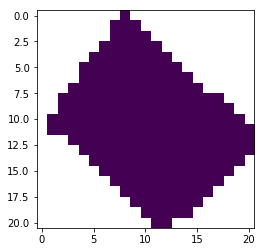

In [64]:
if check_results:

    import matplotlib
    import matplotlib.pyplot as plt

    fig = plt.figure()
    plt.imshow(anomaly_values)
    plt.show()



#### Remove temporay files and folders

In [57]:
rm_cfolder(temp_folder)

os.rmdir(temp_folder)